In [2]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from tqdm.notebook import tqdm
from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
#     fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_ch'])

    for ii, iq in enumerate(iq_list):
#         plot = axs[ii]
        if plot_iq:
            plt.plot(t, iq[0], label="I value, ADC %d"%(config['ro_ch']))
            plt.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_ch']))
            plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
        else:
            plt.plot(t, iq[0], label="input value, ADC %d"%(config['ro_ch']))
        plt.ylabel("a.u.")
        plt.xlabel("Time [us]")
        plt.title("Averages = " + str(config["soft_avgs"]))
        plt.legend()

In [3]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('qick_111_rfbrd_v2.bit') # special firmware and extra drivers
soccfg = soc
print(soccfg)

resetting clocks: 204.8

QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, switch ch 5, maxlen 65536
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_signal_gen_v6 - tProc out

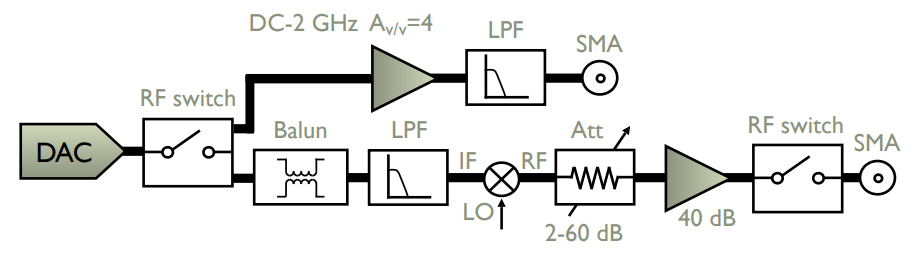

### SET UP CONFIGURATION
note the big attenuations

In [37]:
hw_cfg={"gen_ch":5,
        "ro_ch":0
       }

soc.rfb_set_lo(122.88*60, ch=0, verbose=True) # ADCs
soc.rfb_set_lo(122.88*60, ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(122.88*60, ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['gen_ch'], att1=15, att2=30)

soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 14745.60 |   2 |       2 |  120 |  False |    1 |    1 |     1 |  122.88 |  7372.80 |    0.00 | 2.4000e+02

Choosing solution 0 with minimal metric 240.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 14745.60 |   2 |       2 |  120 |  False |    1 |    1 |     1 |  122.88 |  7372.80 |    0.00 | 2.4000e+02

Choosing solution 0 with minimal metric 240.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|----

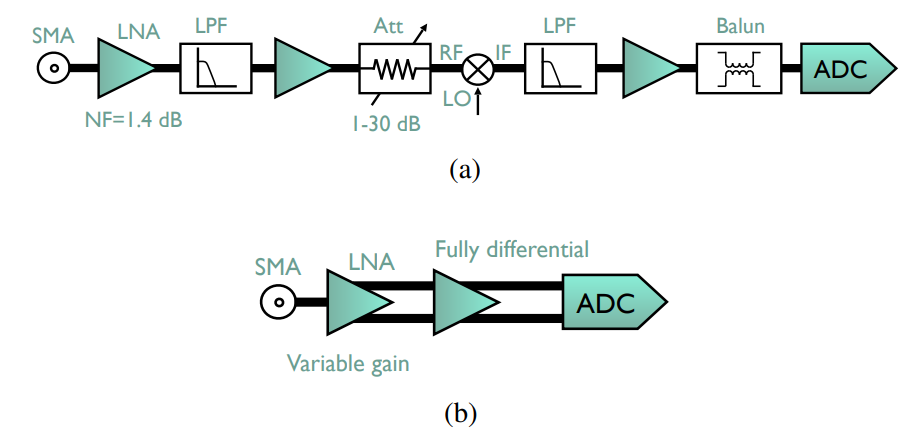

readout IF=872.800000 MHz


  0%|          | 0/1000 [00:00<?, ?it/s]

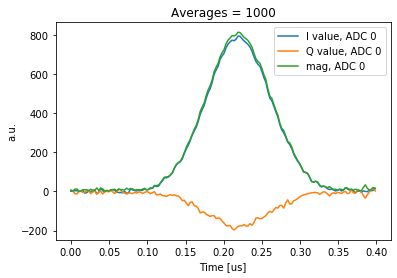

In [40]:
class FSGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        f_if = abs(soc.rfb_get_lo(gen_ch=hw_cfg['gen_ch']) - cfg['pulse_freq'])
        print("readout IF=%f MHz"%(f_if))
        
        
        for iCh, ch in enumerate([cfg["gen_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=1, ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(f_if,gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, freq=f_if,
                                 length=length_ro,
                                 sel=cfg['ro_sel'],
                                 gen_ch=cfg["gen_ch"])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["gen_ch"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=soccfg.us2cycles(self.cfg["adc_trig_offset"]),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
progconfig={
    'ro_sel': 'product',
    'style': 'arb',
    'pulse_gain': 3200,
    'pulse_freq': 6500,
    'adc_trig_offset': 0.35,
    'length': 0.3,
    'readout_padding': 0.1,
    'relax_delay': 1,
    'reps': 1,
    'soft_avgs': 1000
       }
config={**hw_cfg,**progconfig} #combine configs
prog = FSGenLoopbackProgram(soccfg, config)
# print(prog)

soc.rfb_set_gen_rf(gen_ch=hw_cfg['gen_ch'], att1=15, att2=30)

iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

### look at spectra
DC output can go all the way down to DC (which you can't do with a balun) - for pulsed bias

RF output using mixer - note double sidebands

In [ ]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['gen_ch'], att1=10, att2=10)
# soc.rfb_set_gen_dc(gen_ch=hw_cfg['gen_ch'])

soc.rfb_set_lo(122.88*60, ch=2, verbose=True) # DACs 4-7
# soc.rfb_set_lo(122.88*50, ch=2, verbose=True) # DACs 4-7

progconfig={
    'ro_sel': 'product',
    'style': 'arb',
    'pulse_gain': 32000,
    'pulse_freq': 6500,
    'adc_trig_offset': 0.35,
    'length': 1,
    'readout_padding': 0.1,
    'relax_delay': 2,
    'reps': 1000000,
    'soft_avgs': 1
       }
config={**hw_cfg,**progconfig} #combine configs
prog = FSGenLoopbackProgram(soccfg, config)
# print(prog)

while True:
    iq_list = prog.acquire(soc, progress=True)
# Plot results.
# plot_decimated(iq_list, soccfg, config, plot_iq=True)

In [ ]:
#res_range = [5800, 6200]
#qubit_range = [4400, 4900]

# high LO for readout, low LO for qubit, 2:1 relation
# f_lo_ro = 122.88*56 # 6881
# f_lo_qubit = 122.88*28 # 3441

# common LO: low LO for readout, high LO for qubit
# want to keep readout sidebands outside qubit range:
# put LO closer to readout
# f_lo_ro = 122.88*46 # 5652
# f_lo_qubit = 122.88*46
# put LO closer to qubit - probably preferred, since external filter will kill RO lower sideband
# f_lo_ro = 122.88*41 # 5038
# f_lo_qubit = 122.88*41

# various considerations, not all mutually compatible:

# LO performance is best if you use an integer multiple of the reference clock (122.88 MHz)
# LO freqs <7.5 GHz are generated using a divider, so you will see some of the original VCO freq (some multiple of the LO)
# the mixers allow a fair bit of LO leakage, and there also seems to be some crosstalk between LOs
# so you get a cleaner spectrum if you use a single LO
# second best: use LOs that are simple multiples of each other

# the low-pass filter we use on both ADC and DAC IF (LFCN-1800D) is ~2.1 GHz
# the ADC Nyquist freq is ~1.5 GHz, so IFs above ~900 MHz see up to 3 dB more (2x) noise power
# this assumes the noise spectrum is broadband and white
# and it may not be the limiting factor in the measurement - have to see

# on the DAC side, the max IF is just set by the low-pass
# anything up to 1.8 GHz (rated band of the filter) should be OK

# we're using double-sideband mixers, so you will always see both LO+IF and LO-IF, only one of which is desired
# for your qubit drive, this means dumping a lot of power at some random freq - might be harmless?
# for readout, the spur is also going to get mixed back down to your IF, so this basically means you have a second readout path that is always off-resonance
# the RF outputs are low-passed at ~7 GHz (LFCW-6800), so it's nice if you can set your LO high enough that only LO-IF is passed
# or of course you can add an external filter
# VBFZ-6260 only starts really killing stuff below ~4.8, so it is not perfect protection for the qubits
# 

